In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
darknet_english = pd.read_csv('darknet_english_cleaned.csv', encoding='latin1')
darknet_english.head()

,url,body_stripped,language,general_category,specific category
0,http://3h42ncbglpxvc6e5.onion/disclaimer,Apple Market Stolen Carded Merchandise iPhone ...,en,Marketplace,Financial Crime
1,http://naturetome2v7rpsvy4ba3cve35y6llpfcpomvj...,Talk Gout NatureVault Talk Gout Password requi...,en,Forums,General
2,http://zqktlwiuavvvqqt4ybvgvi7tyo4hjl5xgfuvpdf...,public log Hidden Wiki Help public log From Hi...,en,Wiki,General
3,http://6tn2ejdphoveywwt6pc2sbaez62bytq4vr4xd2f...,DNMAdsDenmark Breaking Market Forums data data...,en,Forums,Narcotics
4,http://mm75rpdxcspr7qee.onion/watch/?v=uQL2vvf...,Atheists Forces Nature Immaterial MGTOW Mirror...,en,Unknown,-


In [3]:
subdataset = darknet_english[:200][['body_stripped','general_category']]
subdataset.dropna(inplace=True)
subdataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193 entries, 0 to 199
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   body_stripped     193 non-null    object
 1   general_category  193 non-null    object
dtypes: object(2)
memory usage: 4.5+ KB


In [4]:
subdataset.body_stripped = subdataset.body_stripped.apply(lambda x: x.lower())
train_set = subdataset[:180]
test_set = subdataset[180:]

le = LabelEncoder()
le.fit(train_set['general_category'])

train_set['general_category'] = le.transform(train_set['general_category'])
test_set['general_category'] = le.transform(test_set['general_category'])

train_set.head()

C:\Users\shrey\AppData\Local\Temp/ipykernel_13696/1482392250.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['general_category'] = le.transform(train_set['general_category'])
C:\Users\shrey\AppData\Local\Temp/ipykernel_13696/1482392250.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['general_category'] = le.transform(test_set['general_category'])


,body_stripped,general_category
0,apple market stolen carded merchandise iphone ...,2
1,talk gout naturevault talk gout password requi...,1
2,public log hidden wiki help public log from hi...,6
3,dnmadsdenmark breaking market forums data data...,1
4,atheists forces nature immaterial mgtow mirror...,4


In [6]:
X_train = train_set['body_stripped']
y_train = train_set['general_category']
X_test = test_set['body_stripped']
y_test = test_set['general_category']

#### Set up GPU for training

In [5]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3060 Ti


#### TF-IDF + Naive Bayes Classifier

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Calculate TF-IDF for the training data
tf_idf = TfidfVectorizer(
    ngram_range=(1, 2),
    binary=True,
    smooth_idf=False,
)
X_train_tfidf = tf_idf.fit_transform(X_train)
X_val_tfidf = tf_idf.transform(X_test)

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# Define the parameter values that should be searched
alpha_range = np.arange(1, 10, 0.1)

# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(alpha=alpha_range)

# Instantiate the grid
grid = GridSearchCV(MultinomialNB(), param_grid, cv=10, scoring='accuracy')

# Fit the grid with data
grid.fit(X_train_tfidf, y_train)

# View the complete results
print(grid.cv_results_)

# Examine the best model
print(grid.best_score_)
print(grid.best_params_)

c:\Users\shrey\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


{'mean_fit_time': array([0.00515122, 0.00528958, 0.00370314, 0.0030678 , 0.00464818,
       0.00219927, 0.00316067, 0.00452158, 0.00470154, 0.00513272,
       0.00479743, 0.00344362, 0.00350981, 0.00493417, 0.00467961,
       0.00411041, 0.00449767, 0.00395098, 0.00403566, 0.00447321,
       0.00467849, 0.00276253, 0.00472977, 0.00326767, 0.00300765,
       0.00492675, 0.00420084, 0.00405152, 0.00410068, 0.00421584,
       0.00232084, 0.00454671, 0.00426705, 0.00357921, 0.0045434 ,
       0.00498738, 0.0033138 , 0.00512233, 0.00504405, 0.00426931,
       0.00474241, 0.00359128, 0.00408578, 0.00418441, 0.00318329,
       0.00169499, 0.00196531, 0.00341847, 0.00407648, 0.00510225,
       0.0046046 , 0.00357752, 0.00288186, 0.00337305, 0.00382712,
       0.00486581, 0.00492668, 0.00480201, 0.00491941, 0.00506244,
       0.00276725, 0.0047683 , 0.00399978, 0.0051651 , 0.00460725,
       0.00353889, 0.00383115, 0.00512922, 0.00463538, 0.00502284,
       0.00464752, 0.00494597, 0.00253253, 0

              precision    recall  f1-score   support

           1       1.00      0.33      0.50         3
           2       0.50      1.00      0.67         2
           4       0.00      0.00      0.00         1
           6       0.88      1.00      0.93         7

    accuracy                           0.77        13
   macro avg       0.59      0.58      0.52        13
weighted avg       0.78      0.77      0.72        13



c:\Users\shrey\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\shrey\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\shrey\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

<Axes: >

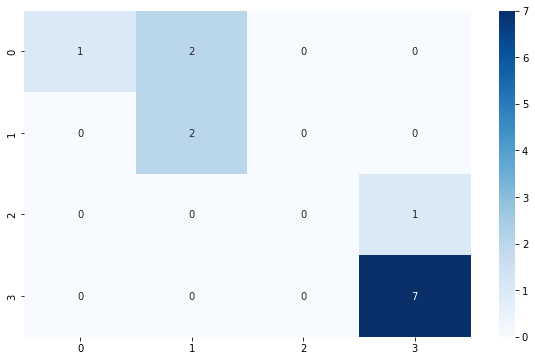

In [26]:
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# train your model using all data and the best known parameters
nb = MultinomialNB(alpha=grid.best_params_['alpha'])
nb.fit(X_train_tfidf, y_train)

# make class predictions for X_test_tfidf
y_pred_class = nb.predict(X_val_tfidf)

# plot confusion matrix
plt.figure(figsize=(10,6))
print(classification_report(y_test, y_pred_class))
sns.heatmap(confusion_matrix(y_test, y_pred_class), annot=True, cmap='Blues')
